### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-1/simple-graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 图结构概览

让我们构建一个包含3个节点和1个条件边的简单图。

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

### 图结构说明
- **START** → **node_1**：固定边，总是从起始节点到第一个节点
- **node_1** → **node_2** 或 **node_3**：条件边，根据随机数决定路径
- **node_2** → **END**：固定边，结束路径
- **node_3** → **END**：固定边，结束路径

这种设计展示了LangGraph的核心特性：**状态管理**和**条件路由**。

In [1]:
# 安装依赖包
# 使用 %%capture 隐藏安装过程的输出信息，保持界面整洁
%%capture --no-stderr
# %pip install --quiet -U langgraph
%pip install langgraph==0.6.7

In [2]:
%pip show langgraph

Name: langgraph
Version: 0.6.7
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: 


## 状态定义（State）

首先，我们需要定义图的[状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)。

### 什么是状态？
状态是LangGraph中最重要的概念之一，它：
- **存储数据**：在整个图执行过程中保持和传递数据
- **类型安全**：为所有节点和边提供统一的输入模式
- **状态共享**：所有节点都可以读取和修改状态

### 状态模式设计
我们使用Python的`TypedDict`类来定义状态模式，它提供了键的类型提示，确保代码的类型安全性。

### 为什么选择TypedDict？
- **类型检查**：IDE可以提供更好的代码补全和错误检查
- **文档化**：清楚地表明状态包含哪些字段
- **运行时安全**：在运行时验证状态结构

**详细解释一下 TypedDict 的用法和作用。**

TypedDict 是 Python typing 模块中的一个工具，它的主要目的是为字典提供类型提示。在 Python 中，普通的字典（dict）非常灵活，但这也意味着你无法在代码编辑阶段确定一个字典里有哪些键，以及每个键对应的值是什么类型。这可能会导致运行时错误。

TypedDict 就像是给字典定义了一个“结构模板”。当你定义一个 TypedDict 时，你需要指定：

- 固定的键集合: 你声明这个字典应该包含哪些键。
- 键的类型: 你为每个键指定它对应的值应该是什么类型。

这样做的好处是：

- 提高代码可读性: 看到 TypedDict 定义，就能清楚地知道这个字典应该长什么样。
- 增强类型安全: 静态类型检查工具（比如 MyPy）可以在你运行代码之前就检查你对字典的使用是否符合定义，帮助你发现潜在的类型错误。
- 更好的开发体验: 大多数现代 IDE 都能根据 TypedDict 提供代码自动补全和参数提示。

**如何使用 TypedDict?**

你需要从 typing 模块（或者在较旧的 Python 版本中使用 typing_extensions）导入 TypedDict。然后，你可以像定义一个类一样来定义你的 TypedDict：
```python
from typing_extensions import TypedDict

# 定义一个表示用户信息的 TypedDict
class UserInfo(TypedDict):
    name: str
    age: int
    is_active: bool
```
在这个例子中，我们定义了一个名为 UserInfo 的 TypedDict，它指定了三个键：name（字符串类型）、age（整数类型）和 is_active（布尔类型）。

现在，当你创建一个符合 UserInfo 结构的字典时，你可以给它加上类型提示：
```python
# 创建一个符合 UserInfo 结构的字典
user: UserInfo = {
    "name": "Alice",
    "age": 30,
    "is_active": True
}

# 如果你尝试添加一个未定义的键，或者使用错误的类型，类型检查工具会发出警告
# user["city"] = "New York" # 类型检查警告：'UserInfo' has no key 'city'
# user["age"] = "thirty"  # 类型检查警告：Value of type "Literal['thirty']" cannot be assigned to key "age" of type "int"
```
在 LangGraph 的例子中，State(TypedDict) 定义了图的状态。graph_state: str 表示这个状态字典必须包含一个名为 graph_state 的键，并且它的值必须是字符串类型。这确保了在图的整个执行过程中，所有节点和边都能以一种类型安全的方式访问和修改这个共享的状态数据。

总的来说，TypedDict 是 Python 中一个非常有用的工具，它弥补了普通字典在类型提示方面的不足，特别适用于需要定义具有固定结构和类型的数据字典的场景，如 API 响应、配置文件或像 LangGraph 这样的状态对象。

In [3]:
# 导入必要的类型定义模块
from typing_extensions import TypedDict

# 定义图的状态模式
# State类继承自TypedDict，为图的状态提供类型安全的结构定义
class State(TypedDict):
    """
    图状态定义

    这是整个图执行过程中共享的数据结构。
    所有节点都可以读取和修改这个状态。

    字段说明：
    - graph_state (str): 存储图执行过程中的文本状态
                        在这个简单示例中，我们用它来累积文本信息
    """
    graph_state: str  # 图状态字段，类型为字符串

## 节点定义（Nodes）

[节点](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)是LangGraph中的基本执行单元，它们就是普通的Python函数。

### 节点函数的特点
- **第一个参数**：必须是状态对象（state），类型为上面定义的`State`
- **返回值**：必须是一个字典，包含要更新的状态字段
- **状态访问**：通过`state['graph_state']`访问状态中的字段
- **状态更新**：返回的字典会[覆盖](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)原有状态值

### 节点执行流程
1. 接收当前状态作为输入
2. 执行特定的业务逻辑
3. 返回包含更新字段的字典
4. LangGraph自动将返回的字段合并到状态中

### 设计原则
- **单一职责**：每个节点只负责一个特定的任务
- **无副作用**：节点不应该直接修改外部状态
- **可测试性**：节点函数应该易于单独测试

In [4]:
def node_1(state: State) -> dict:
    """
    第一个节点：添加" I am"到状态中

    这是图的第一个处理节点，负责在输入文本后添加" I am"。
    这个节点总是会被执行，因为它连接在START节点之后。

    参数:
        state (State): 当前图状态，包含graph_state字段

    返回:
        dict: 包含更新后graph_state的字典
    """
    print("---Node 1---")  # 调试输出，显示节点执行
    # 读取当前状态，添加" I am"，然后返回更新后的状态
    return {"graph_state": state['graph_state'] + " I am"}

def node_2(state: State) -> dict:
    """
    第二个节点：添加" happy!"到状态中

    这个节点代表"开心"的路径，当条件边决定走这个分支时执行。

    参数:
        state (State): 当前图状态

    返回:
        dict: 包含更新后graph_state的字典
    """
    print("---Node 2---")  # 调试输出
    # 添加" happy!"到当前状态
    return {"graph_state": state['graph_state'] + " happy!"}

def node_3(state: State) -> dict:
    """
    第三个节点：添加" sad!"到状态中

    这个节点代表"悲伤"的路径，当条件边决定走这个分支时执行。

    参数:
        state (State): 当前图状态

    返回:
        dict: 包含更新后graph_state的字典
    """
    print("---Node 3---")  # 调试输出
    # 添加" sad!"到当前状态
    return {"graph_state": state['graph_state'] + " sad!"}

## 边定义（Edges）

[边](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)连接图中的节点，定义了数据流的方向。

### 边的类型

#### 1. 普通边（Normal Edges）
- **用途**：当您希望**总是**从一个节点到另一个节点时使用
- **特点**：无条件执行，路径固定
- **示例**：`START` → `node_1`，`node_2` → `END`

#### 2. 条件边（Conditional Edges）
- **用途**：当您希望**有条件地**在节点之间路由时使用
- **特点**：根据某些逻辑动态决定下一个节点
- **实现**：通过函数实现，函数返回下一个要访问的节点名称

### 条件边的优势
- **动态路由**：根据状态内容或外部条件决定执行路径
- **分支逻辑**：支持if-else类型的条件判断
- **灵活控制**：可以实现复杂的业务逻辑流程

### 设计模式
条件边函数通常：
1. 接收当前状态作为参数
2. 基于状态内容或外部条件进行判断
3. 返回下一个要执行的节点名称（字符串）

In [5]:
# 导入必要的模块
import random  # 用于生成随机数
from typing import Literal  # 用于类型提示，限制返回值只能是特定字符串

def decide_mood(state: State) -> Literal["node_2", "node_3"]:
    """
    条件边函数：决定情绪状态

    这是一个条件边函数，根据随机数决定下一个要执行的节点。
    在实际应用中，您可以根据状态内容、用户输入或其他条件来做决定。

    参数:
        state (State): 当前图状态

    返回:
        Literal["node_2", "node_3"]: 下一个要执行的节点名称
                                   - "node_2": 代表开心路径
                                   - "node_3": 代表悲伤路径
    """

    # 在实际应用中，我们通常会根据状态内容来决定下一个节点
    # 这里我们读取状态中的用户输入（虽然在这个简单示例中我们不会使用它）
    user_input = state['graph_state']

    # 这里我们使用简单的50/50随机选择来演示条件边的工作原理
    # 在实际应用中，您可能会基于以下条件做决定：
    # - 用户输入的内容分析
    # - 外部API的响应
    # - 数据库查询结果
    # - 时间、日期等环境因素
    if random.random() < 0.5:
        # 50%的概率返回node_2（开心路径）
        return "node_2"

    # 50%的概率返回node_3（悲伤路径）
    return "node_3"

## 图构建（Graph Construction）

现在，我们使用上面定义的[组件](https://langchain-ai.github.io/langgraph/concepts/low_level/)来构建图。

### 构建步骤

#### 1. 初始化StateGraph
- 使用[StateGraph类](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph)创建图实例
- 传入我们定义的`State`类作为状态模式

#### 2. 添加节点
- 使用`add_node()`方法添加我们定义的节点函数
- 每个节点都有一个唯一的名称标识符

#### 3. 添加边
- **普通边**：使用`add_edge()`方法连接节点
- **条件边**：使用`add_conditional_edges()`方法添加条件路由

#### 4. 特殊节点
- **[START节点](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node)**：特殊的起始节点，接收用户输入
- **[END节点](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node)**：特殊的终止节点，表示图执行结束

#### 5. 编译图
- 使用`compile()`方法[编译图](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph)
- 编译过程会进行基本的结构检查，确保图的正确性

#### 6. 可视化
- 可以将图可视化为[Mermaid图表](https://github.com/mermaid-js/mermaid)
- 帮助理解和调试图的结构

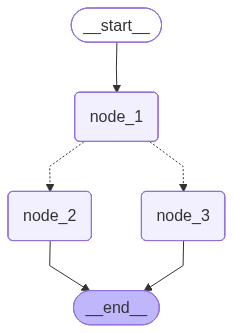

In [6]:
# 导入必要的模块
from IPython.display import Image, display  # 用于在Jupyter中显示图像
from langgraph.graph import StateGraph, START, END  # LangGraph的核心类

# ==================== 图构建过程 ====================

# 1. 初始化StateGraph，传入我们定义的State类
builder = StateGraph(State)

# 2. 添加节点 - 每个节点都有一个唯一的名称和对应的函数
builder.add_node("node_1", node_1)  # 添加第一个节点
builder.add_node("node_2", node_2)  # 添加第二个节点（开心路径）
builder.add_node("node_3", node_3)  # 添加第三个节点（悲伤路径）

# 3. 添加边 - 定义节点之间的连接关系
# 普通边：从START节点到node_1（总是执行）
builder.add_edge(START, "node_1")

# 条件边：从node_1到node_2或node_3（根据decide_mood函数的返回值决定）
builder.add_conditional_edges("node_1", decide_mood)

# 普通边：从node_2到END节点（开心路径结束）
builder.add_edge("node_2", END)

# 普通边：从node_3到END节点（悲伤路径结束）
builder.add_edge("node_3", END)

# 4. 编译图 - 进行结构检查并创建可执行的图
graph = builder.compile()

# 5. 可视化图 - 生成Mermaid图表并显示
# 这有助于理解图的结构和执行流程
display(Image(graph.get_graph().draw_mermaid_png()))

## 图执行（Graph Invocation）

编译后的图实现了[runnable协议](https://python.langchain.com/docs/concepts/runnables/)，这是LangChain生态系统的标准执行接口。

### 执行机制

#### 1. 标准接口
- 编译后的图遵循LangChain的runnable协议
- 提供统一的执行方式，与其他LangChain组件兼容
- `invoke`是标准方法之一，用于同步执行图

#### 2. 输入格式
- 输入是一个字典：`{"graph_state": "Hi, this is lance."}`
- 这个字典设置图状态的初始值
- 键名必须与State类中定义的字段名匹配

#### 3. 执行流程
1. **START节点**：接收输入，开始图执行
2. **node_1**：总是执行，添加" I am"到状态
3. **条件边**：根据随机数决定下一步
   - 50%概率 → **node_2**（开心路径）
   - 50%概率 → **node_3**（悲伤路径）
4. **END节点**：执行结束，返回最终状态

#### 4. 状态传递
- 每个节点接收当前状态作为输入
- 节点返回包含更新字段的字典
- 新值会覆盖原有状态值
- 状态在整个执行过程中保持和传递

### 执行特点
- **同步执行**：`invoke`方法等待每个步骤完成后再继续
- **状态累积**：每个节点都在前一个节点的基础上修改状态
- **条件分支**：根据条件边的逻辑动态选择执行路径

In [10]:
# 执行图 - 使用invoke方法同步执行
# 输入初始状态，开始图的执行流程
result = graph.invoke({"graph_state": "Hi, this is Lance."})

# 显示执行结果
print("执行结果:", result)
print("最终状态:", result['graph_state'])

---Node 1---
---Node 2---
执行结果: {'graph_state': 'Hi, this is Lance. I am happy!'}
最终状态: Hi, this is Lance. I am happy!


### 执行结果分析

`invoke`方法以同步方式运行整个图，这意味着：

#### 执行特点
- **同步等待**：每个步骤完成后才继续下一个步骤
- **完整执行**：等待所有节点执行完毕
- **返回最终状态**：返回图执行完成后的最终状态

#### 可能的执行结果

根据条件边的随机选择，您可能看到以下两种结果之一：

**情况1：开心路径**
```
---Node 1---
---Node 2---
执行结果: {'graph_state': 'Hi, this is Lance. I am happy!'}
```

**情况2：悲伤路径**
```
---Node 1---
---Node 3---
执行结果: {'graph_state': 'Hi, this is Lance. I am sad!'}
```

#### 状态变化过程
1. **初始状态**：`"Hi, this is Lance."`
2. **node_1后**：`"Hi, this is Lance. I am"`
3. **最终状态**：`"Hi, this is Lance. I am happy!"` 或 `"Hi, this is Lance. I am sad!"`

#### 多次执行
由于使用了随机数，每次执行都可能产生不同的结果。您可以多次运行上面的代码来观察不同的执行路径。

## 总结与扩展

### 本教程学到的核心概念

1. **状态管理**：使用TypedDict定义图状态，确保类型安全
2. **节点设计**：将业务逻辑封装为独立的节点函数
3. **条件路由**：使用条件边实现动态执行路径
4. **图构建**：通过StateGraph API构建复杂的执行流程
5. **图执行**：使用invoke方法同步执行图

### 实际应用场景

这个简单示例展示了LangGraph的核心能力，在实际应用中，您可以：

- **聊天机器人**：根据用户输入选择不同的回复策略
- **工作流自动化**：根据条件执行不同的处理步骤
- **决策系统**：基于数据分析和规则进行智能决策
- **多步骤任务**：将复杂任务分解为多个可管理的步骤

### 下一步学习

- **Module 1的其他教程**：学习更复杂的图结构
- **状态管理进阶**：了解复杂状态模式和状态归约器
- **异步执行**：学习使用astream方法进行异步执行
- **错误处理**：学习图的错误处理和恢复机制

### 练习建议

1. 修改条件边函数，基于输入内容而不是随机数做决定
2. 添加更多节点，创建更复杂的执行流程
3. 尝试不同的状态模式，存储更多类型的数据
4. 实验不同的边类型，了解它们的适用场景
